In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import pyplot as plt
import math
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import time
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
import joblib

import xlrd
import csv
from pandas import ExcelWriter
from pandas import ExcelFile


import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#METAL = 'A'
METAL = 'C'

In [3]:
if(METAL == 'A'):
    input_data = './MSc Student Data 2021/data/v2/aluminium/aluminium_22_features.xlsx'
    target_data = 'MSc Student Data 2021/data/v2/aluminium/aluminium_22_target_lagged_log_returns.csv'
else:
    input_data = './MSc Student Data 2021/data/v2/copper/copper_22_features.xlsx'
    target_data = 'MSc Student Data 2021/data/v2/copper/copper_22_target_lagged_log_returns.csv'

In [4]:
input_df = pd.read_excel(input_data)
target_df = pd.read_csv(target_data)

In [5]:
input_df = input_df.rename(columns = {'Unnamed: 0': 'date'}, inplace = False)

In [6]:
input_df = input_df.iloc[3: , :]

In [7]:
input_df.shape

(4187, 45)

In [8]:
target_df.shape

(4187, 2)

In [9]:
input_df['y'] = target_df['y'].values

In [10]:
input_df.columns

Index(['date', 'FeatureFamily.COT', 'FeatureFamily.COT.1',
       'FeatureFamily.COT.2', 'FeatureFamily.CTA', 'FeatureFamily.CTA.1',
       'FeatureFamily.CURVE', 'FeatureFamily.CURVE.1', 'FeatureFamily.CURVE.2',
       'FeatureFamily.CURRENCY', 'FeatureFamily.CURRENCY.1',
       'FeatureFamily.CURRENCY.2', 'FeatureFamily.CURRENCY.3',
       'FeatureFamily.CURRENCY.4', 'FeatureFamily.CURRENCY.5',
       'FeatureFamily.FREIGHT', 'FeatureFamily.FREIGHT.1',
       'FeatureFamily.FREIGHT.2', 'FeatureFamily.FREIGHT.3',
       'FeatureFamily.FREIGHT.4', 'FeatureFamily.FREIGHT.5',
       'FeatureFamily.FREIGHT.6', 'FeatureFamily.FREIGHT.7',
       'FeatureFamily.FREIGHT.8', 'FeatureFamily.FREIGHT.9',
       'FeatureFamily.INVENTORIES', 'FeatureFamily.INVENTORIES.1',
       'FeatureFamily.INVENTORIES.2', 'FeatureFamily.INVENTORIES.3',
       'FeatureFamily.INVENTORIES.4', 'FeatureFamily.INVENTORIES.5',
       'FeatureFamily.SATELLITE', 'FeatureFamily.SATELLITE.1',
       'FeatureFamily.SATELLI

In [11]:
## collect the features with more than 2000 instances
ambudant_features = []
amdudant_features_indexes = []
new_features = []
index = 0
for col_name in input_df.columns:
    number = input_df[col_name].isnull().sum()
    print(col_name + " " + str(number) + " Nan values")
    if(number < 500):
        ambudant_features.append(col_name)
        amdudant_features_indexes.append(index)
    if(number > 1500):
        new_features.append(col_name)
    index += 1

date 0 Nan values
FeatureFamily.COT 293 Nan values
FeatureFamily.COT.1 3326 Nan values
FeatureFamily.COT.2 293 Nan values
FeatureFamily.CTA 63 Nan values
FeatureFamily.CTA.1 32 Nan values
FeatureFamily.CURVE 0 Nan values
FeatureFamily.CURVE.1 348 Nan values
FeatureFamily.CURVE.2 348 Nan values
FeatureFamily.CURRENCY 349 Nan values
FeatureFamily.CURRENCY.1 349 Nan values
FeatureFamily.CURRENCY.2 349 Nan values
FeatureFamily.CURRENCY.3 349 Nan values
FeatureFamily.CURRENCY.4 349 Nan values
FeatureFamily.CURRENCY.5 349 Nan values
FeatureFamily.FREIGHT 2582 Nan values
FeatureFamily.FREIGHT.1 2582 Nan values
FeatureFamily.FREIGHT.2 2582 Nan values
FeatureFamily.FREIGHT.3 2582 Nan values
FeatureFamily.FREIGHT.4 2582 Nan values
FeatureFamily.FREIGHT.5 2587 Nan values
FeatureFamily.FREIGHT.6 2587 Nan values
FeatureFamily.FREIGHT.7 2587 Nan values
FeatureFamily.FREIGHT.8 2587 Nan values
FeatureFamily.FREIGHT.9 2587 Nan values
FeatureFamily.INVENTORIES 2789 Nan values
FeatureFamily.INVENTORIES.1

In [12]:
print(ambudant_features)
print(new_features)
print(len(new_features) + len(ambudant_features))
print(len(input_df.columns))

['date', 'FeatureFamily.COT', 'FeatureFamily.COT.2', 'FeatureFamily.CTA', 'FeatureFamily.CTA.1', 'FeatureFamily.CURVE', 'FeatureFamily.CURVE.1', 'FeatureFamily.CURVE.2', 'FeatureFamily.CURRENCY', 'FeatureFamily.CURRENCY.1', 'FeatureFamily.CURRENCY.2', 'FeatureFamily.CURRENCY.3', 'FeatureFamily.CURRENCY.4', 'FeatureFamily.CURRENCY.5', 'FeatureFamily.SATELLITE', 'FeatureFamily.SATELLITE.1', 'FeatureFamily.SATELLITE.2', 'FeatureFamily.SEASONALITY', 'FeatureFamily.TECHNICAL', 'y']
['FeatureFamily.COT.1', 'FeatureFamily.FREIGHT', 'FeatureFamily.FREIGHT.1', 'FeatureFamily.FREIGHT.2', 'FeatureFamily.FREIGHT.3', 'FeatureFamily.FREIGHT.4', 'FeatureFamily.FREIGHT.5', 'FeatureFamily.FREIGHT.6', 'FeatureFamily.FREIGHT.7', 'FeatureFamily.FREIGHT.8', 'FeatureFamily.FREIGHT.9', 'FeatureFamily.INVENTORIES', 'FeatureFamily.INVENTORIES.1', 'FeatureFamily.INVENTORIES.2', 'FeatureFamily.INVENTORIES.3', 'FeatureFamily.INVENTORIES.4', 'FeatureFamily.INVENTORIES.5', 'FeatureFamily.MACRO', 'FeatureFamily.MACR

In [13]:
historical_features_df = input_df.dropna(subset=ambudant_features)

In [14]:
full_features_df = input_df.dropna(subset=ambudant_features + new_features)

In [15]:
historical_filtered_dates = historical_features_df['date'].values
full_filtered_dates = full_features_df['date'].values

In [16]:
print(historical_filtered_dates)
print(len(historical_filtered_dates))

[datetime.datetime(2006, 8, 30, 0, 0) datetime.datetime(2006, 8, 31, 0, 0)
 datetime.datetime(2006, 9, 1, 0, 0) ...
 datetime.datetime(2021, 5, 12, 0, 0) datetime.datetime(2021, 5, 13, 0, 0)
 datetime.datetime(2021, 5, 14, 0, 0)]
3838


In [17]:
print(full_filtered_dates)
print(len(full_filtered_dates))

[datetime.datetime(2018, 1, 26, 0, 0) datetime.datetime(2018, 1, 29, 0, 0)
 datetime.datetime(2018, 1, 30, 0, 0) datetime.datetime(2018, 1, 31, 0, 0)
 datetime.datetime(2018, 2, 1, 0, 0) datetime.datetime(2018, 2, 2, 0, 0)
 datetime.datetime(2018, 2, 5, 0, 0) datetime.datetime(2018, 2, 6, 0, 0)
 datetime.datetime(2018, 2, 7, 0, 0) datetime.datetime(2018, 2, 8, 0, 0)
 datetime.datetime(2018, 2, 9, 0, 0) datetime.datetime(2018, 2, 12, 0, 0)
 datetime.datetime(2018, 2, 13, 0, 0) datetime.datetime(2018, 2, 14, 0, 0)
 datetime.datetime(2018, 2, 15, 0, 0) datetime.datetime(2018, 2, 16, 0, 0)
 datetime.datetime(2018, 2, 19, 0, 0) datetime.datetime(2018, 2, 20, 0, 0)
 datetime.datetime(2018, 2, 21, 0, 0) datetime.datetime(2018, 2, 22, 0, 0)
 datetime.datetime(2018, 2, 23, 0, 0) datetime.datetime(2018, 2, 26, 0, 0)
 datetime.datetime(2018, 2, 27, 0, 0) datetime.datetime(2018, 2, 28, 0, 0)
 datetime.datetime(2018, 3, 1, 0, 0) datetime.datetime(2018, 3, 2, 0, 0)
 datetime.datetime(2018, 3, 5, 0, 

In [18]:
historical_features_df = historical_features_df.loc[:, historical_features_df.columns != 'date']
historical_features_df=historical_features_df.astype(float)
full_features_df = full_features_df.loc[:, full_features_df.columns != 'date']
full_features_df=full_features_df.astype(float)

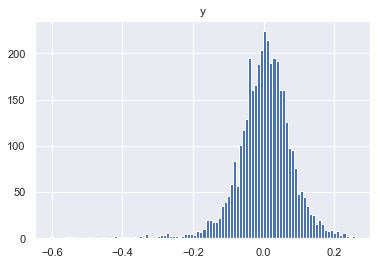

In [19]:
hist = historical_features_df.hist(column = 'y',bins = 100)

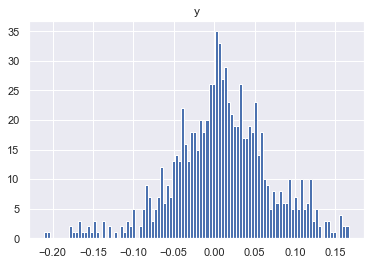

In [20]:
hist = full_features_df.hist(column = 'y',bins = 100)

In [21]:
def normalize(df):
    result = df.copy()
    for i,feature_name in enumerate(df.columns):
        if(i!=0):
            mean_value = df[feature_name].mean()
            std = df[feature_name].std()
            result[feature_name] = (df[feature_name] - mean_value) / (std)
        return result

In [22]:
historical_features = []
for feature in ambudant_features:
    if(feature!='date'):
        historical_features.append(historical_features_df[feature].values)

In [23]:
full_features = []
for feature in ambudant_features + new_features:
    if(feature!='date'):
        full_features.append(full_features_df[feature].values)

In [24]:
historical_filtered_targets = np.array(historical_features[-1])

In [25]:
full_filtered_targets = np.array(full_features[-1])

In [26]:
historical_features = historical_features[0:-1]

In [27]:
full_features = full_features[0:-1]

In [28]:
historical_features = np.array(historical_features).transpose()

In [29]:
full_features = np.array(full_features).transpose()

In [30]:
historical_features.shape

(3838, 18)

In [31]:
full_features.shape

(861, 44)

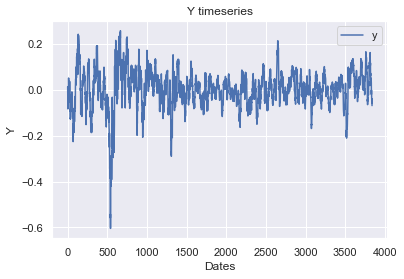

In [32]:
index = [i+1 for i in range(len(historical_filtered_targets))]

plt.plot(index, historical_filtered_targets ,label = "y")
plt.xlabel('Dates')
plt.ylabel('Y')
plt.title('Y timeseries')
plt.legend()
plt.show()
print()

In [33]:
timesteps = 100
inp,lbl,dates = utils.split_timeseries(timesteps,22-2,historical_features,historical_filtered_targets,historical_filtered_dates)

In [34]:
f_inp,f_lbl,f_dates = utils.split_timeseries(timesteps,22-2,full_features,full_filtered_targets,full_filtered_dates)

In [35]:
print(inp.shape)
print(lbl.shape)

(3718, 100, 18)
(3718,)


In [36]:
print(f_inp.shape)
print(f_lbl.shape)

(741, 100, 44)
(741,)


In [37]:
if(METAL == 'A'):
    joblib.dump(inp, '../Vectors/h_aluminium_vectors')
    joblib.dump(lbl, '../Vectors/h_aluminium_labels')
    joblib.dump(dates, '../Vectors/h_aluminium_dates')
    
    joblib.dump(f_inp, '../Vectors/f_aluminium_vectors')
    joblib.dump(f_lbl, '../Vectors/f_aluminium_labels')
    joblib.dump(f_dates, '../Vectors/f_aluminium_dates')
else:
    joblib.dump(inp, '../Vectors/h_copper_vectors')
    joblib.dump(lbl, '../Vectors/h_copper_labels')
    joblib.dump(dates, '../Vectors/h_copper_dates')
    
    joblib.dump(f_inp, '../Vectors/f_copper_vectors')
    joblib.dump(f_lbl, '../Vectors/f_copper_labels')
    joblib.dump(f_dates, '../Vectors/f_copper_dates')

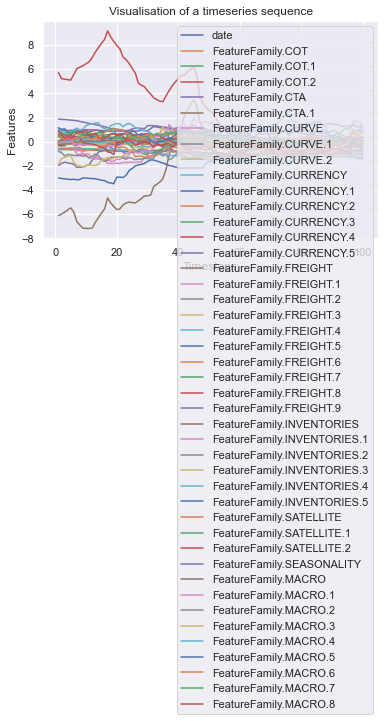

In [38]:
index = 300
#data = inp[index]
data = f_inp[index]

timesteps = [i+1 for i in range(data.shape[0])]
for i in range(data.shape[1]):
    plt.plot(timesteps, data.T[i], label = input_df.columns[i])
    #plt.plot(timesteps, data.T[i])

plt.xlabel('Timesteps')
# Set the y axis label of the current axis.
plt.ylabel('Features')
# Set a title of the current axes.
plt.title('Visualisation of a timeseries sequence')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()